<a href="https://colab.research.google.com/github/tungnt28/Natural-Language-Processing/blob/main/Finalexam_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

## Get comment data from Shopee

In [5]:
import re
import json
import requests
import pandas as pd

def get_cmt_from_shopee_url(url):

    r = re.search(r"i\.(\d+)\.(\d+)", url)
    shop_id, item_id = r[1], r[2]
    ratings_url = "https://shopee.vn/api/v2/item/get_ratings?filter=0&flag=1&itemid={item_id}&limit=50&offset={offset}&shopid={shop_id}&type={rating}"

    # d = {"username": [], "rating": [], "comment": []}
    d = {"comment": [], "rating": []}

    for rate in range(1, 6):
        offset = 0
        while True:
            try:
              data = requests.get(ratings_url.format(shop_id=shop_id, item_id=item_id, offset=offset, rating = rate)).json()

              i = 1
              for i, rating in enumerate(data["data"]["ratings"], 1):
                  d["rating"].append(rating["rating_star"])
                  d["comment"].append(rating["comment"])

                  # print(rating["rating_star"])
                  # print(rating["comment"])
                  # print("-" * 100)

              offset += 50
            except TypeError:
              break
    return d

In [6]:
url = "https://shopee.vn/S%E1%BB%AFa-r%E1%BB%ADa-m%E1%BA%B7t-Simple-l%C3%A0nh-t%C3%ADnh-s%E1%BA%A1ch-tho%C3%A1ng-cho-da-nh%E1%BA%A1y-c%E1%BA%A3m-150ml-CH%C3%8DNH-H%C3%83NG-%C4%90%E1%BB%98C-QUY%E1%BB%80N-DI%E1%BB%86N-M%E1%BA%A0O-M%E1%BB%9AI--i.111138057.8587034871"
df = pd.DataFrame(get_cmt_from_shopee_url(url))
df

,comment,rating
0,Công dụng:rỬa mặt\nMùi hương:ổn\nKết cấu:gel\n...,1
1,Công dụng:sữa rửa mặt\nMùi hương:chưa biết\nDà...,1
2,Dành cho da:lhuf hợp với mọi loại da\nCông dụn...,1
3,Công dụng:Rửa mặt\nMùi hương:Gần như không có\...,1
4,Công dụng:làm sạch\nMùi hương:không biết\nDành...,1
...,...,...
11264,Công dụng:làm sạch bề da mặt\nMùi hương:không ...,5
11265,Công dụng:lamf sạch da\nMùi hương:thơm dịu\nDà...,5
11266,"Nhận hàng, cảm nhận quá tuyệt vời luôn ạ! Shop...",5
11267,Dành cho da:nhạy cảm\nMùi hương:nhẹ\nCông dụng...,5


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/shopee_data_final.csv", index=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11269 entries, 0 to 11268
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  11269 non-null  object
 1   rating   11269 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.2+ KB


In [10]:
num_words = 11268

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
! pip install underthesea==6.6.0
! pip install stop-words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 48.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=8926b0953d098bc9b1339d8f7df8c4f2d3b6c0600a353b3303171b855bde364f
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


##Standarize commnent by Vietnamese and separte words

In [14]:
from underthesea import sent_tokenize
from underthesea import text_normalize
from underthesea import word_tokenize

In [15]:
from stop_words import get_stop_words
from nltk.tokenize import RegexpTokenizer

stop_words = get_stop_words('vi')

def remove_vietnamese_stopwords(words):
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

def assign_label(rating):
  new_class = "neutral"
  if rating>=4:
    new_class = "positive"
  elif rating<=2:
    new_class = "negative"
  return new_class

In [16]:
tokenizer = RegexpTokenizer(r'\w+')
df['words'] = df['comment'].apply(tokenizer.tokenize)
df['words'] = df['words'].apply(remove_vietnamese_stopwords)
df['label'] = df['rating'].apply(assign_label)
df.head(5)

,comment,rating,words,label
0,Công dụng:rỬa mặt\nMùi hương:ổn\nKết cấu:gel\n...,1,Công dụng rỬa mặt Mùi hương ổn Kết cấu gel sho...,negative
1,Công dụng:sữa rửa mặt\nMùi hương:chưa biết\nDà...,1,Công dụng sữa rửa mặt Mùi hương da bình chất v...,negative
2,Dành cho da:lhuf hợp với mọi loại da\nCông dụn...,1,da lhuf hợp da Công dụng sạch da Mùi hương mùi...,negative
3,Công dụng:Rửa mặt\nMùi hương:Gần như không có\...,1,Công dụng Rửa mặt Mùi hương da da Shipper gọi ...,negative
4,Công dụng:làm sạch\nMùi hương:không biết\nDành...,1,Công dụng sạch Mùi hương da tất flashs sale 1 ...,negative


label
positive    6100
negative    3170
neutral     1999
Name: count, dtype: int64


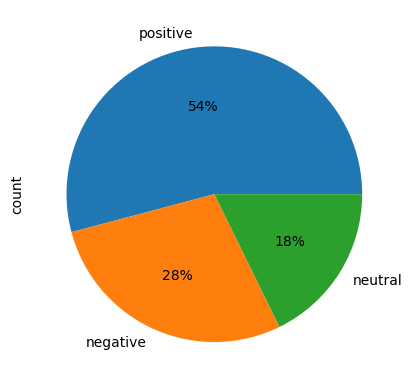

In [17]:
import matplotlib.pyplot as plt
countClass = pd.value_counts(df['label'], sort=True, dropna=False)
print(countClass)
countClass.plot(kind = "pie", autopct= '%1.0f%%')
plt.show()

# Machine Learning

## Naive Bayes Algorithm

In [18]:
def create_word_features(clean_words):
    my_dict = dict([(word, True) for word in clean_words])
    return my_dict

df['feature'] = df['words'].apply(create_word_features)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Convert text data into bag-of-words features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['words'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)


# Initialize and train the Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = NB_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.6015971606033718
              precision    recall  f1-score   support

    negative       0.58      0.50      0.53       662
     neutral       0.20      0.09      0.13       391
    positive       0.66      0.83      0.73      1201

    accuracy                           0.60      2254
   macro avg       0.48      0.47      0.46      2254
weighted avg       0.56      0.60      0.57      2254



In [20]:
print(y_test)

9943     positive
2517     negative
3887      neutral
4981      neutral
6338     positive
           ...   
10764    positive
4598      neutral
6706     positive
5632     positive
8448     positive
Name: label, Length: 2254, dtype: object


Confusion matrix, without normalization
[[328  48 286]
 [123  36 232]
 [117  92 992]]
Normalized confusion matrix
[[0.49546828 0.07250755 0.43202417]
 [0.31457801 0.09207161 0.59335038]
 [0.09741882 0.07660283 0.82597835]]


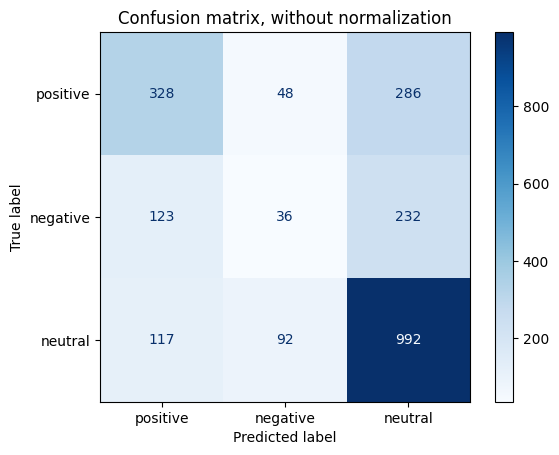

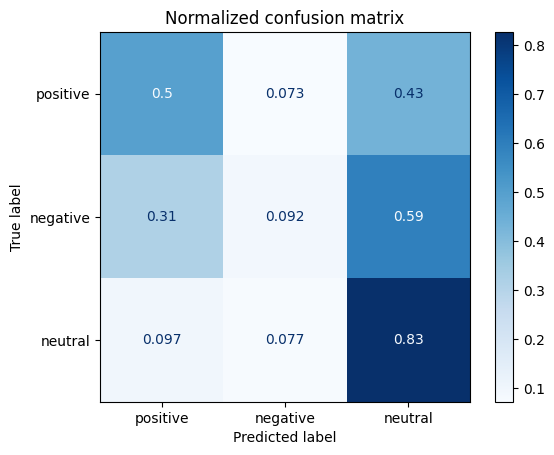

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        NB_model,
        X_test,
        y_test,
        display_labels=["positive", "negative", "neutral"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Support Vector Machine (SVM)

In [22]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['words'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
svc_model = SVC(kernel='linear')  # You can try different kernels like 'linear', 'rbf', etc.
svc_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svc_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.69698314108252
              precision    recall  f1-score   support

    negative       0.57      0.81      0.67       662
     neutral       0.28      0.04      0.07       391
    positive       0.81      0.85      0.83      1201

    accuracy                           0.70      2254
   macro avg       0.55      0.57      0.52      2254
weighted avg       0.65      0.70      0.65      2254



Confusion matrix, without normalization
[[ 535   17  110]
 [ 245   15  131]
 [ 158   22 1021]]
Normalized confusion matrix
[[0.8081571  0.02567976 0.16616314]
 [0.62659847 0.03836317 0.33503836]
 [0.13155704 0.01831807 0.8501249 ]]


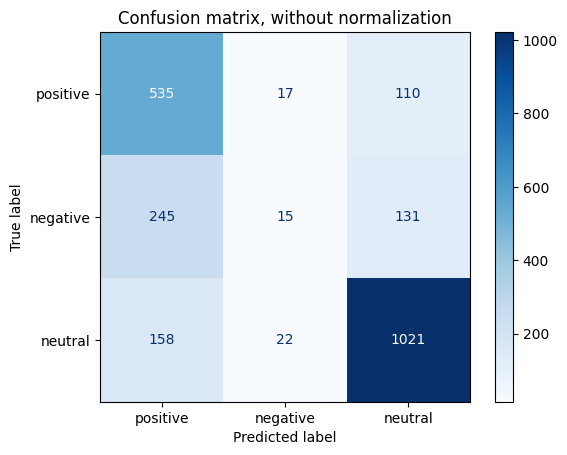

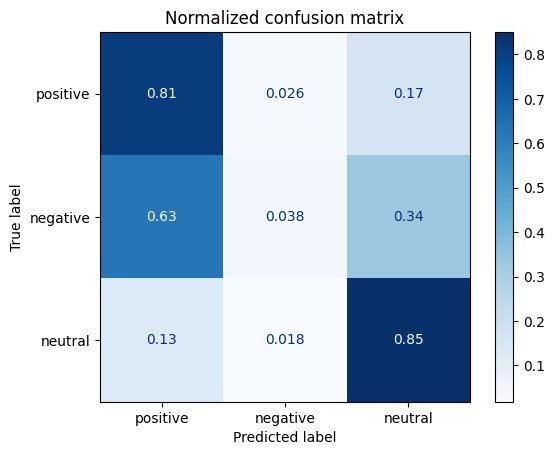

In [23]:
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svc_model,
        X_test,
        y_test,
        display_labels=["positive", "negative", "neutral"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Logistic Regression

In [24]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Check for and handle None values in the 'sentiment' column
df['label'].fillna('None', inplace=True)

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["words"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df["label"], test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_regression_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7067435669920142
              precision    recall  f1-score   support

    negative       0.60      0.79      0.68       662
     neutral       0.29      0.06      0.10       391
    positive       0.81      0.87      0.84      1201

    accuracy                           0.71      2254
   macro avg       0.56      0.57      0.54      2254
weighted avg       0.66      0.71      0.66      2254



Confusion matrix, without normalization
[[ 525   23  114]
 [ 234   23  134]
 [ 122   34 1045]]
Normalized confusion matrix
[[0.79305136 0.0347432  0.17220544]
 [0.59846547 0.05882353 0.342711  ]
 [0.10158201 0.02830974 0.87010824]]


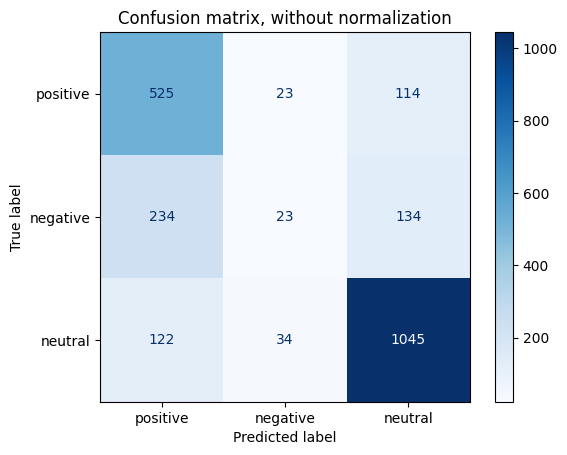

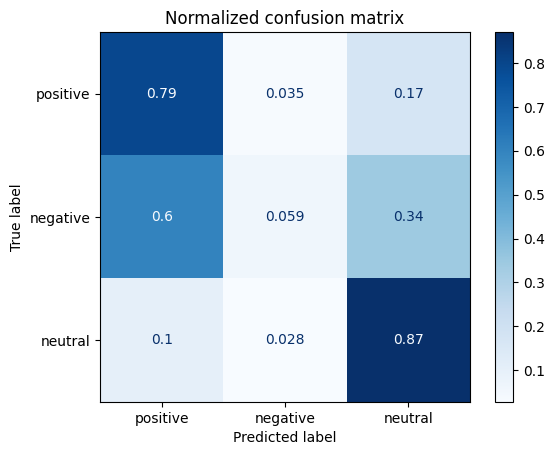

In [25]:
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        logistic_regression_model,
        X_test,
        y_test,
        display_labels=["positive", "negative", "neutral"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Decision Tree

In [26]:
# Import necessary libraries
from sklearn import tree

# Check for and handle None values in the 'sentiment' column
df['label'].fillna('None', inplace=True)

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["words"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df["label"], test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.6162377994676131
              precision    recall  f1-score   support

    negative       0.52      0.65      0.57       662
     neutral       0.19      0.11      0.14       391
    positive       0.77      0.76      0.77      1201

    accuracy                           0.62      2254
   macro avg       0.49      0.51      0.49      2254
weighted avg       0.59      0.62      0.60      2254



Confusion matrix, without normalization
[[427  86 149]
 [224  44 123]
 [177 106 918]]
Normalized confusion matrix
[[0.64501511 0.12990937 0.22507553]
 [0.57289003 0.11253197 0.31457801]
 [0.14737719 0.08825978 0.76436303]]


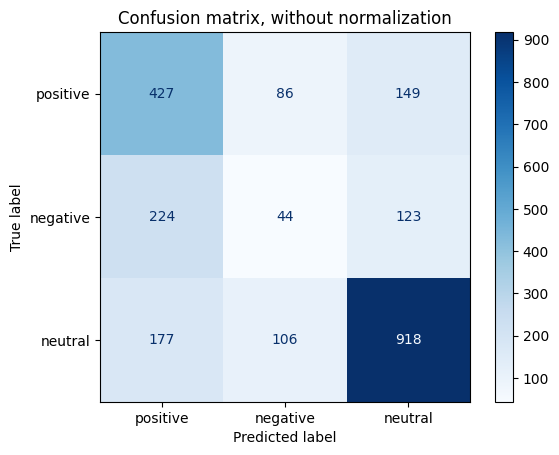

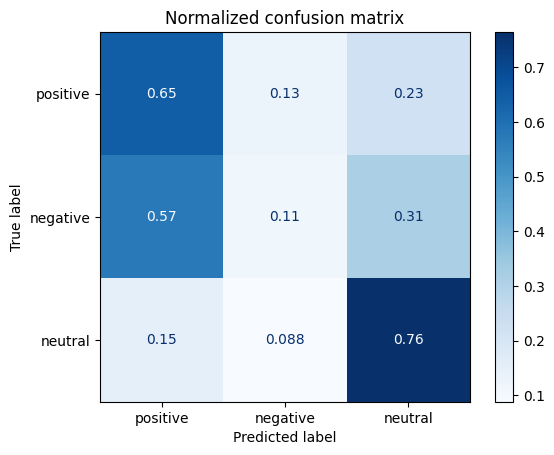

In [27]:
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        decision_tree_model,
        X_test,
        y_test,
        display_labels=["positive", "negative", "neutral"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Deep learning

In [28]:
def create_word_features(clean_words):
    my_dict = dict([(word, True) for word in clean_words])
    return my_dict

df['feature'] = df['words'].apply(create_word_features)

In [29]:
df.head()

,comment,rating,words,label,feature
0,Công dụng:rỬa mặt\nMùi hương:ổn\nKết cấu:gel\n...,1,Công dụng rỬa mặt Mùi hương ổn Kết cấu gel sho...,negative,"{'C': True, 'ô': True, 'n': True, 'g': True, '..."
1,Công dụng:sữa rửa mặt\nMùi hương:chưa biết\nDà...,1,Công dụng sữa rửa mặt Mùi hương da bình chất v...,negative,"{'C': True, 'ô': True, 'n': True, 'g': True, '..."
2,Dành cho da:lhuf hợp với mọi loại da\nCông dụn...,1,da lhuf hợp da Công dụng sạch da Mùi hương mùi...,negative,"{'d': True, 'a': True, ' ': True, 'l': True, '..."
3,Công dụng:Rửa mặt\nMùi hương:Gần như không có\...,1,Công dụng Rửa mặt Mùi hương da da Shipper gọi ...,negative,"{'C': True, 'ô': True, 'n': True, 'g': True, '..."
4,Công dụng:làm sạch\nMùi hương:không biết\nDành...,1,Công dụng sạch Mùi hương da tất flashs sale 1 ...,negative,"{'C': True, 'ô': True, 'n': True, 'g': True, '..."


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['label'])
encoded_labels = le.transform(df['label'])

# Convert text data into bag-of-words features
# vectorizer = CountVectorizer()
# x = vectorizer.fit_transform(df['words'])

In [31]:
df['label_num'] = encoded_labels

In [32]:
df.head(-50)

,comment,rating,words,label,feature,label_num
0,Công dụng:rỬa mặt\nMùi hương:ổn\nKết cấu:gel\n...,1,Công dụng rỬa mặt Mùi hương ổn Kết cấu gel sho...,negative,"{'C': True, 'ô': True, 'n': True, 'g': True, '...",0
1,Công dụng:sữa rửa mặt\nMùi hương:chưa biết\nDà...,1,Công dụng sữa rửa mặt Mùi hương da bình chất v...,negative,"{'C': True, 'ô': True, 'n': True, 'g': True, '...",0
2,Dành cho da:lhuf hợp với mọi loại da\nCông dụn...,1,da lhuf hợp da Công dụng sạch da Mùi hương mùi...,negative,"{'d': True, 'a': True, ' ': True, 'l': True, '...",0
3,Công dụng:Rửa mặt\nMùi hương:Gần như không có\...,1,Công dụng Rửa mặt Mùi hương da da Shipper gọi ...,negative,"{'C': True, 'ô': True, 'n': True, 'g': True, '...",0
4,Công dụng:làm sạch\nMùi hương:không biết\nDành...,1,Công dụng sạch Mùi hương da tất flashs sale 1 ...,negative,"{'C': True, 'ô': True, 'n': True, 'g': True, '...",0
...,...,...,...,...,...,...
11214,tôi đã mua 10000000 lần yêu srm này lắm 🥺😭💗 dù...,5,mua 10000000 yêu srm lắm sạch mềm da nma makeu...,positive,"{'m': True, 'u': True, 'a': True, ' ': True, '...",2
11215,Mùi hương:khong mui\nDành cho da:moi loai da\n...,5,Mùi hương khong mui da moi loai da Công dụng s...,positive,"{'M': True, 'ù': True, 'i': True, ' ': True, '...",2
11216,Công dụng:sạch da\nMùi hương:nhẹ '\nDành cho d...,5,Công dụng sạch da Mùi hương nhẹ da nhạy cảm da...,positive,"{'C': True, 'ô': True, 'n': True, 'g': True, '...",2
11217,Dành cho da:mọi loại da\nMùi hương:không mùi\n...,5,da da Mùi hương mùi Công dụng sạch da mặt mua ...,positive,"{'d': True, 'a': True, ' ': True, 'M': True, '...",2


In [33]:
# Split the data into training and testing sets
x_train_text, x_test_text, y_train, y_test = train_test_split(df['words'], df['label_num'], test_size= 0.2, random_state = 42)

In [34]:
x_train_text.shape

(9015,)

In [35]:
x_test_text.shape

(2254,)

In [36]:
x_train_text[1]

'Công dụng sữa rửa mặt Mùi hương da bình chất vỏ nghi ngờ chất'

In [37]:
# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [38]:
# # Conver to numpy arrays
# x_train_text = np.array(x_train_text)
# x_test_text = np.array(x_test_text)

In [39]:
x_train_text.shape

(9015,)

In [40]:
# print("Train-set size: ", len(x_train_text))
# print("Test-set size:  ", len(x_test_text))

In [41]:
x_train_text[1]

'Công dụng sữa rửa mặt Mùi hương da bình chất vỏ nghi ngờ chất'

**Tokenization**


In [42]:
num_words = 10000

In [43]:
tokenizer = Tokenizer(num_words=num_words)

In [44]:
%%time
tokenizer.fit_on_texts(df['words'])

CPU times: user 503 ms, sys: 3.33 ms, total: 506 ms
Wall time: 882 ms


In [45]:
if num_words is None:
    num_words = len(tokenizer.word_index)

In [46]:
tokenizer.word_index

{'da': 1,
 'mùi': 2,
 'hàng': 3,
 'dụng': 4,
 'hương': 5,
 'công': 6,
 'mặt': 7,
 'rửa': 8,
 'mua': 9,
 'giao': 10,
 'shop': 11,
 'gói': 12,
 'ko': 13,
 'tặng': 14,
 'đóng': 15,
 'sạch': 16,
 'k': 17,
 'phẩm': 18,
 'sản': 19,
 'cảm': 20,
 'trang': 21,
 'tẩy': 22,
 'nhẹ': 23,
 'nhạy': 24,
 '1': 25,
 'giá': 26,
 'sữa': 27,
 'hợp': 28,
 'chất': 29,
 'ok': 30,
 'đc': 31,
 'nha': 32,
 'chai': 33,
 'lắm': 34,
 'sài': 35,
 'srm': 36,
 'dịu': 37,
 'kèm': 38,
 'thơm': 39,
 'cẩn': 40,
 'thận': 41,
 'hơi': 42,
 'ổn': 43,
 'sử': 44,
 'khô': 45,
 'sơ': 46,
 'quà': 47,
 'phù': 48,
 '2': 49,
 'sp': 50,
 'hình': 51,
 'đầu': 52,
 'bao': 53,
 'vọng': 54,
 'dầu': 55,
 'mụn': 56,
 'ảnh': 57,
 'xài': 58,
 'simple': 59,
 'sale': 60,
 'rẻ': 61,
 'chống': 62,
 'hộp': 63,
 'xong': 64,
 'thất': 65,
 'bọc': 66,
 'đẹp': 67,
 'hộ': 68,
 'ủng': 69,
 'kh': 70,
 'mall': 71,
 'nắp': 72,
 'ứng': 73,
 'hãng': 74,
 'sốc': 75,
 'mn': 76,
 'thử': 77,
 'hôm': 78,
 'bì': 79,
 '3': 80,
 'kích': 81,
 'đánh': 82,
 'bảo': 83,
 '

In [47]:
x_train_tokens = tokenizer.texts_to_sequences(x_train_text)

In [48]:
x_train_text[1]

'Công dụng sữa rửa mặt Mùi hương da bình chất vỏ nghi ngờ chất'

In [49]:
np.array(x_train_tokens[1])

array([   2,    5, 2730,  533,    1,    1,    6,    4,    8,    7,   16,
          3,   15,   12,   40,   41,   42,    2, 2730,  533,  161,   93,
         16,   30,   37,   23,   26,   48,   28,  861, 1237,    9])

In [50]:
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)

In [51]:
len(x_train_tokens),len(x_test_text)

(9015, 2254)

Padding and Truncating Data

In [52]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

The average number of tokens in a sequence is:

In [53]:
np.mean(num_tokens)

15.642115538202148

The maximum number of tokens in a sequence is:

In [54]:
np.max(num_tokens)

330

Số lượng token tối đa cho phép được đặt ở mức trung bình cộng với 2 độ lệch chuẩn.

In [55]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

41

In [56]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9743544236400745

Khi thêm hoặc cắt các chuỗi có độ dài khác nhau, chúng ta cần quyết định liệu chúng ta muốn thực hiện việc thêm hoặc cắt 'pre' hay 'post'. Nếu một chuỗi bị cắt, điều đó có nghĩa là một phần của chuỗi được loại bỏ. Nếu một chuỗi được thêm, điều đó có nghĩa là các số không được thêm vào chuỗi.

Đúng, việc lựa chọn 'pre' hoặc 'post' có thể quan trọng vì nó xác định liệu chúng ta sẽ loại bỏ phần đầu hay phần cuối của một chuỗi khi cắt, và nó xác định liệu chúng ta sẽ thêm các số không vào đầu hoặc cuối của chuỗi khi thêm. Điều này có thể làm rối loạn Recurrent Neural Network.

In [57]:
pad = 'pre'

In [58]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

In [59]:
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

Bây giờ chúng ta đã biến đổi tập dữ liệu huấn luyện thành một ma trận lớn chứa các số nguyên (token) có hình dạng:

In [60]:
x_train_pad.shape

(9015, 41)

The matrix for the test-set has the same shape:

In [61]:
x_test_pad.shape


(2254, 41)

In [62]:
np.array(x_train_tokens[1])

array([   2,    5, 2730,  533,    1,    1,    6,    4,    8,    7,   16,
          3,   15,   12,   40,   41,   42,    2, 2730,  533,  161,   93,
         16,   30,   37,   23,   26,   48,   28,  861, 1237,    9])


Đây đã được đệm đơn giản để tạo ra chuỗi sau. Lưu ý rằng khi đầu vào này được đưa vào Recurrent Neural Network, nó trước tiên đầu vào nhiều số không. Nếu chúng ta đã đệm 'post' thì nó sẽ đầu vào các số nguyên trước và sau đó là nhiều số không. Điều này có thể làm rối loạn Recurrent Neural Network..

In [63]:
x_train_pad[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    2,    5,
       2730,  533,    1,    1,    6,    4,    8,    7,   16,    3,   15,
         12,   40,   41,   42,    2, 2730,  533,  161,   93,   16,   30,
         37,   23,   26,   48,   28,  861, 1237,    9], dtype=int32)

##Tokenizer Inverse Map

In [64]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [65]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]

    # Concatenate all words.
    text = " ".join(words)

    return text

In [66]:
x_train_text[1]

'Công dụng sữa rửa mặt Mùi hương da bình chất vỏ nghi ngờ chất'

In [67]:
tokens_to_string(x_train_tokens[1])

'mùi hương chàm trà da da công dụng rửa mặt sạch hàng đóng gói cẩn thận hơi mùi chàm trà dạng gel sạch ok dịu nhẹ giá phù hợp hs sv mua'

##Create the Recurrent Neural Network

In [68]:
# Xây dựng mô hình RNN
model = Sequential()

In [69]:
embedding_size = 8

The embedding-layer also needs to know the number of words in the vocabulary (num_words) and the length of the padded token-sequences (max_tokens). We also give this layer a name because we need to retrieve its weights further below.

In [70]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))

We can now add the first Gated Recurrent Unit (GRU) to the network. This will have 16 outputs. Because we will add a second GRU after this one, we need to return sequences of data because the next GRU expects sequences as its input.

In [71]:
model.add(GRU(units=16, return_sequences=True))

In [72]:
model.add(GRU(units=8, return_sequences=True))

In [73]:
model.add(GRU(units=4))

In [74]:
model.add(Dense(3, activation='sigmoid'))

In [75]:
optimizer = Adam(lr=1e-3)

In [76]:
# Biên dịch mô hình
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_embedding (Embedding  (None, 41, 8)             80000     
 )                                                               
                                                                 
 gru (GRU)                   (None, 41, 16)            1248      
                                                                 
 gru_1 (GRU)                 (None, 41, 8)             624       
                                                                 
 gru_2 (GRU)                 (None, 4)                 168       
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
Total params: 82055 (320.53 KB)
Trainable params: 82055 (320.53 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

##Train the Recurrent Neural Network


We can now train the model. Note that we are using the data-set with the paddedsequences. We use 5% of the training-set as a small validation-set, so we have a rough idea whether the model is generalizing well or if it is perhaps over-fitting to the training-set.

In [78]:
x_train_pad

array([[   0,    0,    0, ...,   11,  475, 1051],
       [   0,    0,    0, ...,  861, 1237,    9],
       [   0,    0,    0, ...,   29,   82,   26],
       ...,
       [   0,    0,    0, ...,   35,   10,    3],
       [   0,    0,    0, ...,    8,    7,  162],
       [   0,    0,    0, ...,   12,    3,  345]], dtype=int32)

In [79]:
y_train

array([2, 2, 2, ..., 2, 0, 2])

In [80]:
%%time
model.fit(x_train_pad, y_train,
          validation_split=0.05, epochs=3, batch_size=64)

Epoch 1/3
134/134 [==============================] - 16s 66ms/step - loss: 0.9107 - accuracy: 0.5850 - val_loss: 0.7607 - val_accuracy: 0.6807
Epoch 2/3
134/134 [==============================] - 6s 45ms/step - loss: 0.7238 - accuracy: 0.6961 - val_loss: 0.6987 - val_accuracy: 0.7051
Epoch 3/3
134/134 [==============================] - 7s 55ms/step - loss: 0.6687 - accuracy: 0.7167 - val_loss: 0.6918 - val_accuracy: 0.7095
CPU times: user 36.3 s, sys: 1.03 s, total: 37.3 s
Wall time: 48 s


Performance on Test-Set


In [81]:
%%time
result = model.evaluate(x_test_pad, y_test)

71/71 [==============================] - 1s 19ms/step - loss: 0.7144 - accuracy: 0.6988
CPU times: user 1.2 s, sys: 35.2 ms, total: 1.23 s
Wall time: 2.73 s


In [82]:
print("Accuracy: {0:.2%}".format(result[1]))

Accuracy: 69.88%


## Example of Mis-Classified Text

In [83]:
%%time
y_pred = model.predict(x=x_test_pad[0:1000])
y_pred = y_pred.T[0]

32/32 [==============================] - 2s 14ms/step
CPU times: user 2.04 s, sys: 35.9 ms, total: 2.07 s
Wall time: 2.75 s


In [84]:
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in y_pred])

In [85]:
cls_true = np.array(y_test[0:1000])

In [86]:
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]

In [87]:
len(incorrect)

840

In [88]:
idx = incorrect[0]
idx

0

In [89]:
text = x_test_text[idx]
text

'Công dụng rỬa mặt Mùi hương ổn Kết cấu gel shop giao 1 tuýp lành lặn tuýp băng bó băng dính dở ship k lí j lỗi Đóng gói cẩn thận giao hàng'

In [90]:
y_pred[idx]

0.2536174

In [91]:
cls_true[idx]

2

## New Data

In [92]:
text1 = "Sản phẩm rất tuyệt mọi người nên dùng thử"
text2 = "Sản phẩm tốt"
text3 = "Tôi thích sản phẩm này"
text4 = "Bình thường"
text5 = "Ok"
text6 = "Sản phẩm không phù hợp"
text7 = "Sản phẩm tệ, kém chất lượng"
text8 = "Tôi không thích sản phẩm này, có thể hoàn tiền lại không?"
texts = [text1, text2, text3, text4, text5, text6, text7, text8]

In [93]:
tokens = tokenizer.texts_to_sequences(texts)

In [94]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
tokens_pad.shape

(8, 41)

In [95]:
model.predict(tokens_pad)

1/1 [==============================] - 0s 50ms/step


array([[0.43144166, 0.46441495, 0.73908216],
       [0.5862758 , 0.46447483, 0.41698727],
       [0.5862758 , 0.46447483, 0.41698727],
       [0.60227484, 0.4647844 , 0.37753424],
       [0.5260879 , 0.47653732, 0.5590555 ],
       [0.4292531 , 0.46347675, 0.73998266],
       [0.6632944 , 0.4777973 , 0.21978723],
       [0.6290639 , 0.4575151 , 0.30296728]], dtype=float32)

A value close to 0.0 means a negative sentiment and a value close to 1.0 means a positive sentiment. These numbers will vary every time you train the model.

## Embeddings

In [96]:
layer_embedding = model.get_layer('layer_embedding')

In [97]:
weights_embedding = layer_embedding.get_weights()[0]

In [98]:
weights_embedding.shape

(10000, 8)

In [99]:
token_good = tokenizer.word_index['đen']
token_good

977

In [100]:
token_great = tokenizer.word_index['tuyệt']
token_great

198

In [101]:
weights_embedding[token_good]

array([-0.01043146,  0.04024279, -0.00597815,  0.0238607 ,  0.04592841,
        0.00975737,  0.03047192, -0.00333958], dtype=float32)

In [102]:
weights_embedding[token_great]

array([-0.10164957, -0.1291076 , -0.14449777,  0.06884264, -0.05431428,
       -0.14061268,  0.0879513 , -0.06572095], dtype=float32)

In [103]:
token_bad = tokenizer.word_index['dở']
token_horrible = tokenizer.word_index['tệ']

In [104]:
weights_embedding[token_bad]

array([ 0.04594126,  0.01139731, -0.0166044 ,  0.00114778,  0.02614721,
        0.02572938,  0.00702855,  0.02659528], dtype=float32)

In [105]:
weights_embedding[token_horrible]

array([ 0.24644306,  0.14436626,  0.2136528 , -0.19732453,  0.21592669,
        0.19024009, -0.21956849,  0.2639705 ], dtype=float32)

## Sorted Words
We can also sort all the words in the vocabulary according to their "similarity" in the embedding-space. We want to see if words that have similar embedding-vectors also have similar meanings.

Similarity of embedding-vectors can be measured by different metrics, e.g. Euclidean distance or cosine distance.

We have a helper-function for calculating these distances and printing the words in sorted order.

In [106]:
def print_sorted_words(word, metric='cosine'):

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding],
                      metric=metric).T[0]

    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)

    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]

    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [inverse_map[token] for token in sorted_index
                    if token != 0]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

    print("...")

    # Print the words with highest embedding-distance.
    _print_words(sorted_words[-k:], sorted_distances[-k:])

# Long short-term memory

Biến đổi nhãn chuỗi thành số

In [109]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Biến đổi nhãn chuỗi thành số
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X = df['words']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
max_words = 10000  # Số lượng từ tối đa trong từ điển
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [111]:
max_seq_length = 100
X_train_seq = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_seq_length)

In [112]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))

In [113]:
# Biên dịch mô hình
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(X_train_seq, y_train, epochs=10, batch_size=64, validation_data=(X_test_seq, y_test))

# Đánh giá mô hình
y_pred = model.predict(X_test_seq)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Epoch 1/10
141/141 [==============================] - 45s 296ms/step - loss: 0.7559 - accuracy: 0.6692 - val_loss: 0.6893 - val_accuracy: 0.6877
Epoch 2/10
141/141 [==============================] - 35s 252ms/step - loss: 0.6208 - accuracy: 0.7266 - val_loss: 0.6665 - val_accuracy: 0.6810
Epoch 3/10
141/141 [==============================] - 35s 246ms/step - loss: 0.5625 - accuracy: 0.7486 - val_loss: 0.6724 - val_accuracy: 0.7209
Epoch 4/10
141/141 [==============================] - 36s 259ms/step - loss: 0.5137 - accuracy: 0.7676 - val_loss: 0.7043 - val_accuracy: 0.6979
Epoch 5/10
141/141 [==============================] - 37s 266ms/step - loss: 0.4766 - accuracy: 0.7840 - val_loss: 0.7429 - val_accuracy: 0.6704
Epoch 6/10
141/141 [==============================] - 35s 250ms/step - loss: 0.4457 - accuracy: 0.7996 - val_loss: 0.8009 - val_accuracy: 0.6704
Epoch 7/10
141/141 [==============================] - 36s 258ms/step - loss: 0.4182 - accuracy: 0.8131 - val_loss: 0.8052 - val_ac

In [114]:
# Tạo một đối tượng SMOTE
smote = SMOTE(random_state=42)

# Áp dụng SMOTE cho dữ liệu huấn luyện
X_train_seq_resampled, y_train_resampled = smote.fit_resample(X_train_seq, y_train)

# Chia dữ liệu sau khi áp dụng SMOTE
X_train_resampled, _, y_train_resampled, _ = train_test_split(X_train_seq_resampled, y_train_resampled, test_size=0.2, random_state=42)

# Xây dựng mô hình deep learning
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))  # 3 là số lớp (tích cực, tiêu cực, trung lập)

# Biên dịch mô hình
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình trên dữ liệu đã được mở rộng
model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, validation_data=(X_test_seq, y_test))

# Đánh giá mô hình
y_pred = model.predict(X_test_seq)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Epoch 1/10
184/184 [==============================] - 60s 268ms/step - loss: 0.9141 - accuracy: 0.5240 - val_loss: 0.7637 - val_accuracy: 0.6730
Epoch 2/10
184/184 [==============================] - 44s 241ms/step - loss: 0.7861 - accuracy: 0.6084 - val_loss: 0.7310 - val_accuracy: 0.6539
Epoch 3/10
184/184 [==============================] - 45s 245ms/step - loss: 0.7056 - accuracy: 0.6508 - val_loss: 0.7654 - val_accuracy: 0.6464
Epoch 4/10
184/184 [==============================] - 46s 250ms/step - loss: 0.6390 - accuracy: 0.6928 - val_loss: 0.8479 - val_accuracy: 0.6171
Epoch 5/10
184/184 [==============================] - 45s 246ms/step - loss: 0.5817 - accuracy: 0.7188 - val_loss: 0.8109 - val_accuracy: 0.6398
Epoch 6/10
184/184 [==============================] - 45s 243ms/step - loss: 0.5378 - accuracy: 0.7361 - val_loss: 0.8506 - val_accuracy: 0.6269
Epoch 7/10
184/184 [==============================] - 48s 263ms/step - loss: 0.4981 - accuracy: 0.7550 - val_loss: 0.9071 - val_ac

Epoch 1/10
141/141 [==============================] - 40s 284ms/step - loss: 0.4706 - accuracy: 0.8017 - val_loss: 0.8211 - val_accuracy: 0.6832
Epoch 2/10
141/141 [==============================] - 35s 247ms/step - loss: 0.3841 - accuracy: 0.8293 - val_loss: 0.9254 - val_accuracy: 0.6810
Epoch 3/10
141/141 [==============================] - 37s 265ms/step - loss: 0.3499 - accuracy: 0.8455 - val_loss: 0.9408 - val_accuracy: 0.6783
Epoch 4/10
141/141 [==============================] - 38s 269ms/step - loss: 0.3275 - accuracy: 0.8548 - val_loss: 1.0336 - val_accuracy: 0.6713
Epoch 5/10
141/141 [==============================] - 35s 249ms/step - loss: 0.3027 - accuracy: 0.8637 - val_loss: 1.1002 - val_accuracy: 0.6797
Epoch 6/10
141/141 [==============================] - 49s 346ms/step - loss: 0.3099 - accuracy: 0.8570 - val_loss: 1.1258 - val_accuracy: 0.6761
Epoch 7/10
141/141 [==============================] - 34s 239ms/step - loss: 0.2923 - accuracy: 0.8646 - val_loss: 1.1685 - val_ac

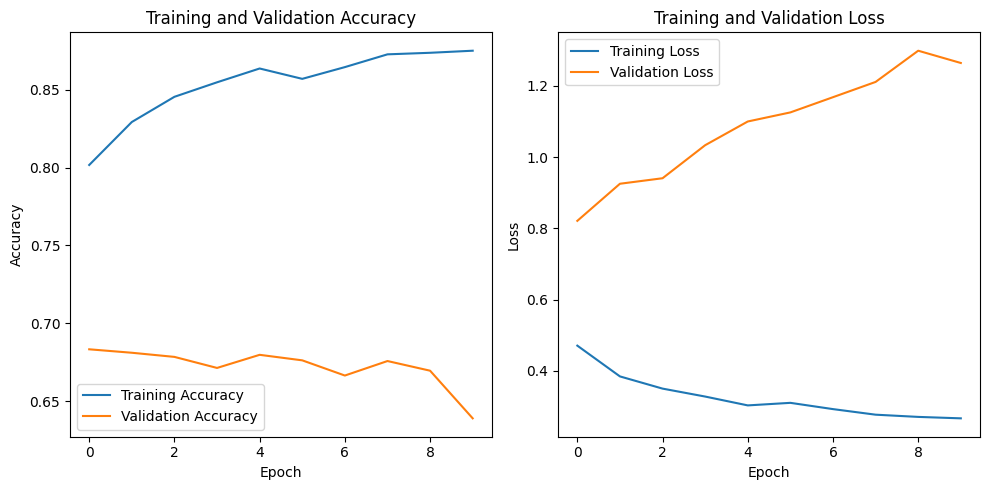

In [115]:
import matplotlib.pyplot as plt

# Huấn luyện mô hình và lưu lịch sử huấn luyện
history = model.fit(X_train_seq, y_train, epochs=10, batch_size=64, validation_data=(X_test_seq, y_test))

# Lấy thông tin lịch sử huấn luyện
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Biểu diễn độ chính xác
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Biểu diễn mất mát
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()